In [1]:
import arviz as az
import numpy as np
import pymc3 as pm
import scipy.stats as st
import matplotlib.pyplot as plt

from sbi import *

https://en.wikipedia.org/wiki/Approximate_Bayesian_computation

https://docs.pymc.io/en/v3/pymc-examples/examples/samplers/SMC-ABC_Lotka-Volterra_example.html

https://www.readcube.com/articles/10.3389/feart.2015.00054

In [2]:
# Read in Katies model runs
Young2020 = xr.open_dataset("notebooks/Young_etal_2020_Delta_T_-0.9_C.nc")
# Fit the air temperature function to Katies results
AirTemp_params = fit_airtemp(Young2020)
# instantiate the AirTemp class using the parameters from the curve fitting
Temp = AirTemp(**AirTemp_params)

# Read in the lilk model results
with xr.open_dataset('../../initialization/coarse/result/lilk-a/nc/lilk-a_1000a_dt_1_dx_200_MB_00.0_OFF.nc') as src:
    # correct for minimum ice thickness
    src["depth"] = xr.where(src.depth <= 10, 0, src.depth)
    # apply sigma coordinate transform for vertical coordinate
    src["Z"]     = src.zbed + src.Z * src.height
    # Calculate the magnitude of the velocity vectors
    src['vel_m'] = np.sqrt(src['velocity 1']**2 + src['velocity 2']**2)

# Surface Elevation Vector
Z      = src.Z.isel(t=-1, coord_2=-1).values[np.newaxis, :]
MB     = src["zs accumulation flux 2"].isel(t=-1, coord_2=-1).values[np.newaxis, :]

z_ref  = Young2020.stack(z=('x', 'y')).Elevation.mean().values
A_mean = Young2020.stack(z=('x', 'y')).Accumulation.values[
          np.argpartition(np.abs(Young2020.stack(z=('x', 'y')).Elevation.values - z_ref), 25)][:25].mean() * 910.0

In [3]:
# instantiate the MassBalance class
model = MassBalance(Z=Z, Temp=Temp, A_mean=A_mean)

def simulator(f_snow, f_r, grad_A):
    return model.eval(f_snow=f_snow, f_r=f_r, grad_A=grad_A)

In [13]:
with pm.Model() as model_mb:
    # Braithwaite (2008) / Rounce et al. 2020
    f_snow = pm.TruncatedNormal("f_snow", mu=4.1, sigma=1.5, lower=0)  
    # Naive refreezing factor prior
    f_r    = pm.Uniform("f_r", 0.0, 1.0)
    # Percipitation Lapse Rate
    grad_A = pm.TruncatedNormal("grad_A", mu=4.0e-4, sigma=1.0e-3, lower=0)  
    
    
    sim = pm.Simulator("sims", simulator, params=(f_snow, f_r, grad_A), epsilon=0.1, observed=MB)
    
    trace_mb = pm.sample_smc(draws=5000, kernel="ABC", chains=3, parallel=False)
    idata_mb = az.from_pymc3(trace_mb,)


Initializing SMC sampler...
Sampling 3 chains in 2 jobs
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.000
Stage:   3 Beta: 0.000
Stage:   4 Beta: 0.001
Stage:   5 Beta: 0.001
Stage:   6 Beta: 0.002
Stage:   7 Beta: 0.003
Stage:   8 Beta: 0.005
Stage:   9 Beta: 0.010
Stage:  10 Beta: 0.021
Stage:  11 Beta: 0.043
Stage:  12 Beta: 0.096
Stage:  13 Beta: 0.215
Stage:  14 Beta: 0.479
Stage:  15 Beta: 1.000
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.000
Stage:   3 Beta: 0.000
Stage:   4 Beta: 0.001
Stage:   5 Beta: 0.001
Stage:   6 Beta: 0.002
Stage:   7 Beta: 0.003
Stage:   8 Beta: 0.006
Stage:   9 Beta: 0.011
Stage:  10 Beta: 0.022
Stage:  11 Beta: 0.045
Stage:  12 Beta: 0.101
Stage:  13 Beta: 0.226
Stage:  14 Beta: 0.503
Stage:  15 Beta: 1.000
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.000
Stage:   3 Beta: 0.000
Stage:   4 Beta: 0.001
Stage:   5 Beta: 0.001
Stage:   6 Beta: 0.002
Stage:   7 Beta: 0.003
Stage:   8 Beta: 0.006
S

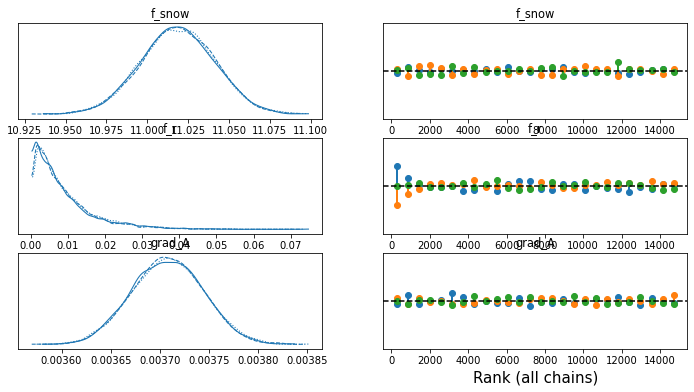

In [14]:
az.plot_trace(idata_mb, kind="rank_vlines");

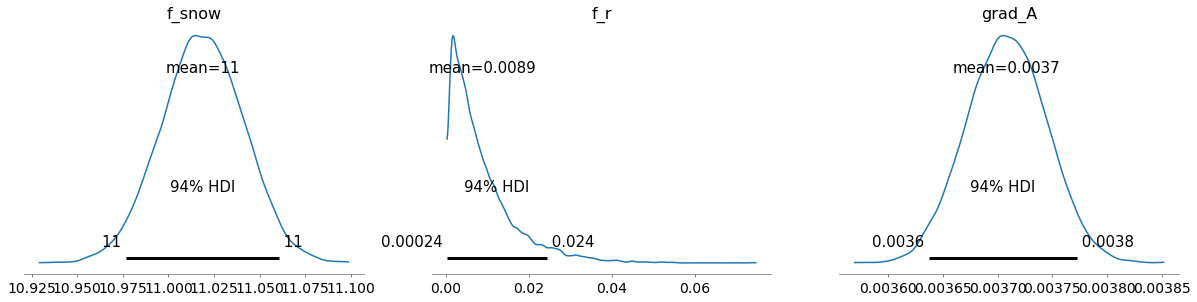

In [15]:
az.plot_posterior(idata_mb);

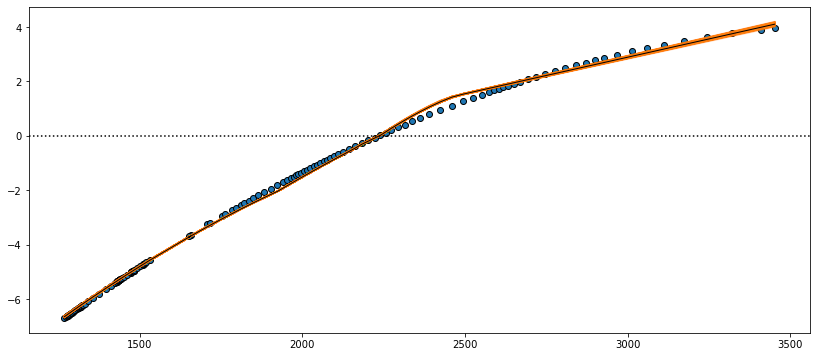

In [16]:
# plot results
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(Z[0], MB[0,:], "o", label="prey", c="C0", mec="k")


for i in np.random.randint(0, len(trace_mb["f_snow"]), 1000):
    sim = simulator(trace_mb["f_snow"][i], trace_mb["f_r"][i], trace_mb["grad_A"][i]);
    ax.plot(Z[0], sim[0], alpha=0.1, c="C1")
    
ax.plot(Z[0], simulator(trace_mb["f_snow"].mean(),  
                        trace_mb["f_r"].mean(),
                        trace_mb["grad_A"].mean())[0], 
        c = 'k', linewidth=1.0);

ax.axhline(0.0, c='k', ls=":")

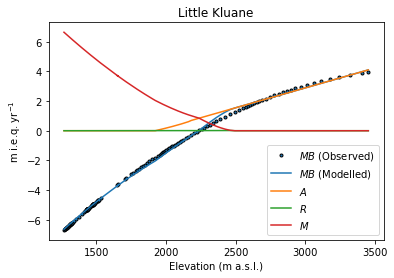

In [17]:
_ = model.eval(f_snow=trace_mb["f_snow"].mean(),  
               f_r=trace_mb["f_r"].mean(),
               grad_A=trace_mb["grad_A"].mean())[0]


fig, ax = plt.subplots(1,1)

ax.plot(Z[0], MB[0], 'o', c="C0", mec="k", ms=3.0, label='$MB$ (Observed)')
ax.plot(Z[0], model.arrays['MB'][0], label='$MB$ (Modelled)')
ax.plot(Z[0], model.arrays['A' ][0]*(1/910), label="$A$")
ax.plot(Z[0], model.arrays['R' ][0]*(1/910), label="$R$")
ax.plot(Z[0], model.arrays['M' ][0]*(1/910), label="$M$")

ax.legend()
ax.set_title('Little Kluane')
ax.set_ylabel('m i.e.q. yr$^{-1}$')
ax.set_xlabel('Elevation (m a.s.l.)')

plt.savefig("/Users/andrewnolan/Desktop/MB_component.png", dpi=300, 
            bbox_inches='tight', facecolor='w')

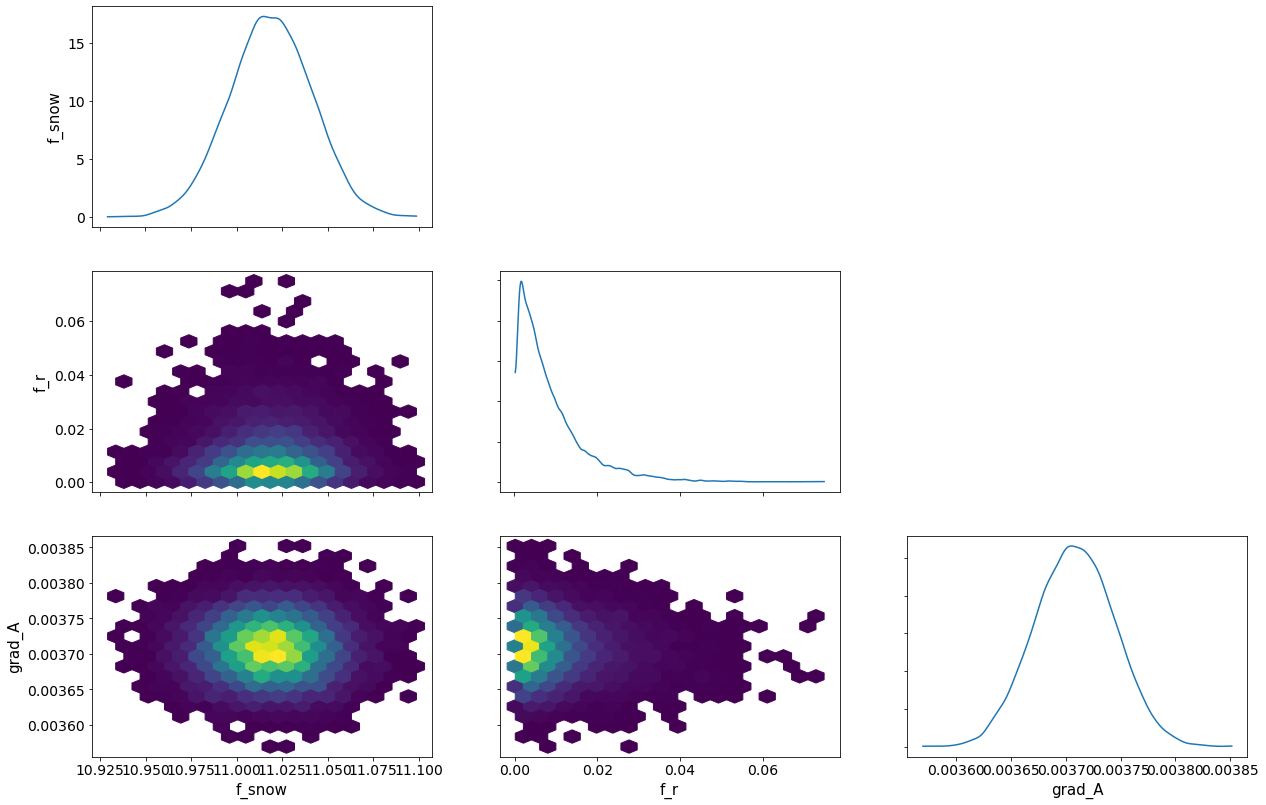

In [20]:
axes = az.plot_pair( idata_mb, 
                     kind="hexbin",
                     marginals=True)

plt.savefig('/Users/andrewnolan/Desktop/posteriors.png', dpi=300, 
            bbox_inches='tight', facecolor='w')